In [17]:
!pip install missingno
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import missingno as mno
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

project_id = 'formation-data-science'
bucket_name = 'formation_data_science' 
file_name = 'fr.openfoodfacts.org.products.csv'
target_gcloud = '/tmp/fr.openfoodfacts.org.products.csv'
target_local = 'fr.openfoodfacts.org.products.csv'
target_local_samples = 'fr.openfoodfacts.org.products.sample_1000.csv'
# workplace = 'LOCAL'
#workplace = 'LOCAL_SAMPLE'
workplace = 'GCLOUD'

pd.options.display.max_rows = 170
pd.set_option('display.multi_sparse', False)

#% matplotlib inline
sns.set_style()

if 'LOCAL' == workplace:
    food_data = pd.read_csv(target_local, sep='\t', low_memory=False, dtype={'code': 'object'})
    target = target_local
elif 'LOCAL_SAMPLE' == workplace:
    food_data = pd.read_csv(target_local_samples, low_memory=False, dtype={'code': 'object'})
    target = target_local_samples
elif 'GCLOUD' == workplace:
    target = target_gcloud
    if  not os.path.exists(target_gcloud):
        from google.colab import auth
        auth.authenticate_user()
        !gcloud config set project {project_id}
        !gsutil cp gs://{bucket_name}/{file_name} {target_gcloud}
    food_data = pd.read_csv(target_gcloud, sep='\t', low_memory=False, dtype={'code': 'object'})
else:
    print('Unknown workplace')
   

In [0]:

#Convert to date
food_data['created_datetime'] = pd.to_datetime(food_data['created_datetime'], errors='coerce', infer_datetime_format=True)
food_data['last_modified_datetime'] = pd.to_datetime(food_data['last_modified_datetime'], errors='coerce', infer_datetime_format=True)

#Missing data
food_data_count = food_data.count('index')
food_data_rows = len(food_data)
missing_data = pd.DataFrame({'Percentage': 1-(food_data_count/food_data_rows), 'Count': food_data_rows-food_data_count}).sort_values(by='Count')
food_data_clean = food_data.copy()
na_percentage_cutoff = 0.8 # 0.6 --> columns with more than 60% missing values will be removed
valid_cols = missing_data[missing_data['Percentage']<=na_percentage_cutoff].index.values
food_data_clean = food_data_clean[valid_cols]

#Let's remove the duplicated fields and keep only english tagging
for f in food_data_clean.columns.values:
    tags_n_fr = [f+'_tags', f+'_fr']
    food_data_clean = food_data_clean.drop(tags_n_fr, axis=1, errors='ignore')
    
# And remove additional columns that won't of any use
columns_not_used = ['url', 'created_t', 'last_modified_t', 'image_small_url', 'image_url', 'brands', 'ingredients_text', 'quantity', 'packaging', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_from_palm_oil_n', 'states', 'serving_size', 'categories']
food_data_clean = food_data_clean.drop(columns_not_used, axis=1, errors='ignore')
food_data_clean = food_data_clean.drop(index=food_data_clean[food_data_clean['product_name'].isna()].index.values)
food_data_clean = food_data_clean.drop(index=food_data_clean[food_data_clean['code'].isna()].index.values)
food_data_clean[['pnns_groups_1', 'pnns_groups_2']] = food_data_clean[['pnns_groups_1', 'pnns_groups_2']].replace('unknown', np.nan)


energy_100g K with minimal MSE: 2 (MSE= 0.11594528670667373 )
proteins_100g K with minimal MSE: 2 (MSE= 0.3655585136125134 )
salt_100g K with minimal MSE: 10 (MSE= 0.5126491086282086 )
sodium_100g K with minimal MSE: 10 (MSE= 0.512682753065638 )
additives_n K with minimal MSE: 2 (MSE= 1.0245274971076959 )
sugars_100g K with minimal MSE: 2 (MSE= 0.38353671232155323 )
fat_100g K with minimal MSE: 10 (MSE= 0.13490058910527486 )
carbohydrates_100g K with minimal MSE: 2 (MSE= 0.20465651814980007 )
saturated-fat_100g K with minimal MSE: 10 (MSE= 0.36703234911874133 )
nutrition-score-uk_100g K with minimal MSE: 2 (MSE= 0.12478758024913739 )
nutrition-score-fr_100g K with minimal MSE: 2 (MSE= 0.15682718239877805 )
fiber_100g K with minimal MSE: 2 (MSE= 0.5734801571313349 )
cholesterol_100g K with minimal MSE: 10 (MSE= 0.5919562087959601 )
trans-fat_100g K with minimal MSE: 5 (MSE= 1.229004854773235 )
calcium_100g K with minimal MSE: 2 (MSE= 0.5140426323385249 )
vitamin-c_100g K with minimal MS

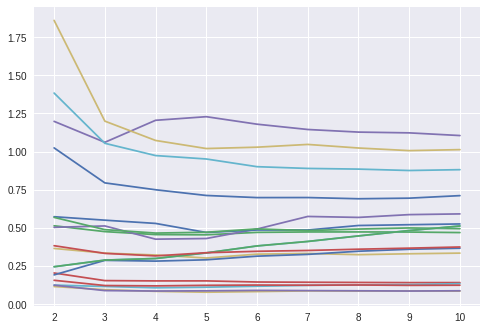

{'additives_n': 2,
 'calcium_100g': 2,
 'carbohydrates_100g': 2,
 'cholesterol_100g': 10,
 'energy_100g': 2,
 'fat_100g': 10,
 'fiber_100g': 2,
 'iron_100g': 2,
 'nutrition-score-fr_100g': 2,
 'nutrition-score-uk_100g': 2,
 'proteins_100g': 2,
 'salt_100g': 10,
 'saturated-fat_100g': 10,
 'sodium_100g': 10,
 'sugars_100g': 2,
 'trans-fat_100g': 5,
 'vitamin-a_100g': 2,
 'vitamin-c_100g': 2}

In [9]:
# Create reference table
food_ref_table = food_data_clean.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

# Standardize the reference table (only numeric columns)
scaler = StandardScaler().fit(food_ref_table.select_dtypes(include=[np.number]))
numeric_columns = food_ref_table.select_dtypes(include=[np.number]).columns.tolist()
food_ref_table_n = food_ref_table.copy()
food_ref_table_n[numeric_columns] = scaler.transform(food_ref_table_n[numeric_columns])

#food_ref_table_n_train, food_ref_table_n_test = train_test_split(food_ref_table_n, train_size=0.7)

kfold = KFold(n_splits=5, shuffle=True)
K_max = 10
mse_total = {k: [] for k in food_ref_table_n[numeric_columns]}
for train, test in kfold.split(food_ref_table_n):
    food_ref_table_n_train = food_ref_table_n.iloc[train]
    food_ref_table_n_test = food_ref_table_n.iloc[test]

    for field in food_ref_table_n_test[numeric_columns]:
#        mse_total[field] = []
        # Using sklearn NearestNeighbors return n_neighbors for each row order by ascending distances
        neighbors = NearestNeighbors(n_neighbors=K_max, metric='euclidean').fit(food_ref_table_n_train[numeric_columns].drop(columns=(field)))
        indices = neighbors.kneighbors(food_ref_table_n_test[numeric_columns].drop(columns=(field)), return_distance=False)
        
        # Finding the K_max nearest neighbors
        neighbors_values = []
        for index in indices:
            neighbors_values.append(food_ref_table_n_train.iloc[index][field].values)       
        
        # Computing the mean for K neighbors with K=1...K_max and corresponding MSE
        mse = []
        for k in range(1, K_max):
            predicted = np.array(neighbors_values)[:,0:k].mean(axis=1)
            mse.append(mean_squared_error(food_ref_table_n_test[field], predicted))
    
        mse_total[field].append(np.array(mse))

mse_cv = {}    
field_optimal_K = {}
for field, val in mse_total.items():
    mse_cv[field] = np.array(val).mean(axis=0)
    print(field, "K with minimal MSE:", np.argmax(mse_cv[field])+2, "(MSE=", max(mse_cv[field]),")")
    field_optimal_K[field] = np.argmax(mse_cv[field])+2
   
mse_cv = pd.DataFrame(mse_cv)
mse_cv.index = mse_cv.index+2 # To get index = K
plt.plot(mse_cv)
plt.show()
field_optimal_K

In [15]:
# Let's try to impute the missing values
food_data_imputed = food_data_clean.copy().sample(50000)
food_data_imputed = food_data_imputed.dropna(axis=0, how='all', subset=numeric_columns)
before = food_data_imputed.isna().sum()

for row in food_data_imputed.iterrows():
    idx = row[0]
    values = row[1]
    nan_columns_numeric = [col for col in values.index[values.isna()].values if col in numeric_columns]
    nan_columns_not_numeric = [col for col in values.index[values.isna()].values if col not in numeric_columns]
    not_nan_columns_numeric = [col for col in values.index[~values.isna()].values if col in numeric_columns]
    
    if not not_nan_columns_numeric:
        print("Only NAN values in ", row)
    else:
        # Create with number of neighbors corresponding to the max K value that will be used
        knn = NearestNeighbors(n_neighbors=K_max, metric='euclidean').fit(food_ref_table_n[not_nan_columns_numeric])
        neighbors = knn.kneighbors(values_n, n_neighbors=field_optimal_K[max(field_optimal_K)], return_distance=False)[0]
        
        # Standardize numeric variables
        scaler = StandardScaler().fit(food_ref_table[not_nan_columns_numeric])
        values_n = scaler.transform(values[not_nan_columns_numeric].values.reshape(1, -1).tolist())
        food_data_imputed.loc[idx, not_nan_columns_numeric] = values_n[0]
        
        # Impute missing data for numeric fields
        for col in nan_columns_numeric:
            k_optimal = field_optimal_K[col]
            indices = neighbors[0:k_optimal]
            food_data_imputed.loc[idx, col] = food_ref_table_n[col].iloc[indices].mean()
        # Impute missing data for non-numeric fields
        for col in nan_columns_not_numeric:
            k_optimal = 10 # Optimal K was not assessed 
            indices = neighbors[0:k_optimal]
            food_data_imputed.loc[idx, col] = food_ref_table_n[col].iloc[indices].mode()[0]

after = food_data_imputed.isna().sum()
pd.concat([before, after], axis=1)

,0,1
creator,0,0
code,0,0
last_modified_datetime,0,0
created_datetime,0,0
countries,14,0
product_name,0,0
energy_100g,2437,0
proteins_100g,2621,0
salt_100g,3310,0
sodium_100g,3317,0


In [18]:
pca = PCA(n_components=5)

#PCA
pca.fit(food_data_imputed[0:1000][numeric_columns])
print(["{:.2%}".format(x) for x in pca.explained_variance_ratio_])

pca.fit(food_data_imputed[0:5000][numeric_columns])
print(["{:.2%}".format(x) for x in pca.explained_variance_ratio_])

pca.fit(food_data_imputed[0:10000][numeric_columns])
print(["{:.2%}".format(x) for x in pca.explained_variance_ratio_])

pca.fit(food_data_imputed[0:25000][numeric_columns])
print(["{:.2%}".format(x) for x in pca.explained_variance_ratio_])

pca.fit(food_data_imputed[0:50000][numeric_columns])
print(["{:.2%}".format(x) for x in pca.explained_variance_ratio_])

food_data_imputed_pca = pca.transform(food_data_imputed[numeric_columns])
food_data_imputed_pca = np.hstack((food_data_imputed_pca, food_data_imputed['nutrition_grade_fr'].values.reshape(-1, 1)))
food_data_imputed_pca = pd.DataFrame(food_data_imputed_pca, columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'nutrition_grade_fr'])
#food_data_imputed_pca[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] = food_data_imputed_pca[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']].as_type('float64')
#food_data_imputed_pca['nutrition_grade_fr'] = food_data_imputed_pca['nutrition_grade_fr'].as_type('category', ordered=True, categories=['a', 'b', 'c', 'd'])


['36.25%', '16.92%', '14.47%', '8.77%', '6.64%']
['24.59%', '19.03%', '15.84%', '11.19%', '7.87%']
['81.27%', '7.89%', '2.76%', '2.34%', '1.55%']
['50.60%', '44.18%', '4.46%', '0.62%', '0.04%']
['47.14%', '41.20%', '5.88%', '4.69%', '0.88%']


In [19]:
food_data_imputed.to_csv("/tmp/target.csv")
!gsutil cp  /tmp/target.csv gs://{bucket_name}/target.csv

Copying file:///tmp/target.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/67.2 MiB.                                     


In [0]:
from google.colab import files
files.download("/tmp/target.csv")